# ASSIGNMENT 2 - LOAN AMOUNT PREDICTION USING LINEAR  REGRESSION

# NAME: A.S.TRITTHIK THILAGAR
# REG NO: 3122237001057

********************************

Mounted at /content/drive
Loaded the datasets
Train shape: (30000, 24)
Test shape : (20000, 23)
------------------------------


/tmp/ipython-input-2-3673704000.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
/tmp/ipython-input-2-3673704000.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Preprocessing complete.
------------------------------
Linear Regression pipeline ready.
------------------------------
Performing 5-Fold Cross-Validation with Linear Regression...
------------------------------
📊 Cross-Validation R² Scores: [0.627 0.624 0.611 0.622 0.656]
📉 Average R² Score: 0.6279
📈 Standard Deviation of R²: 0.0149
------------------------------
Training final Linear Regression model...
*** R2 SCORE:  0.6298398990460499


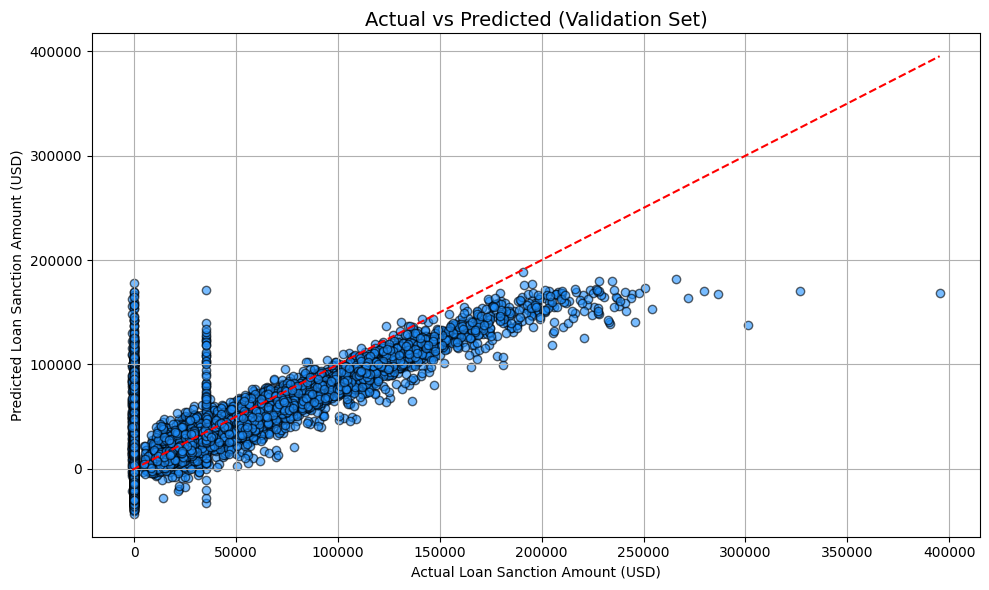

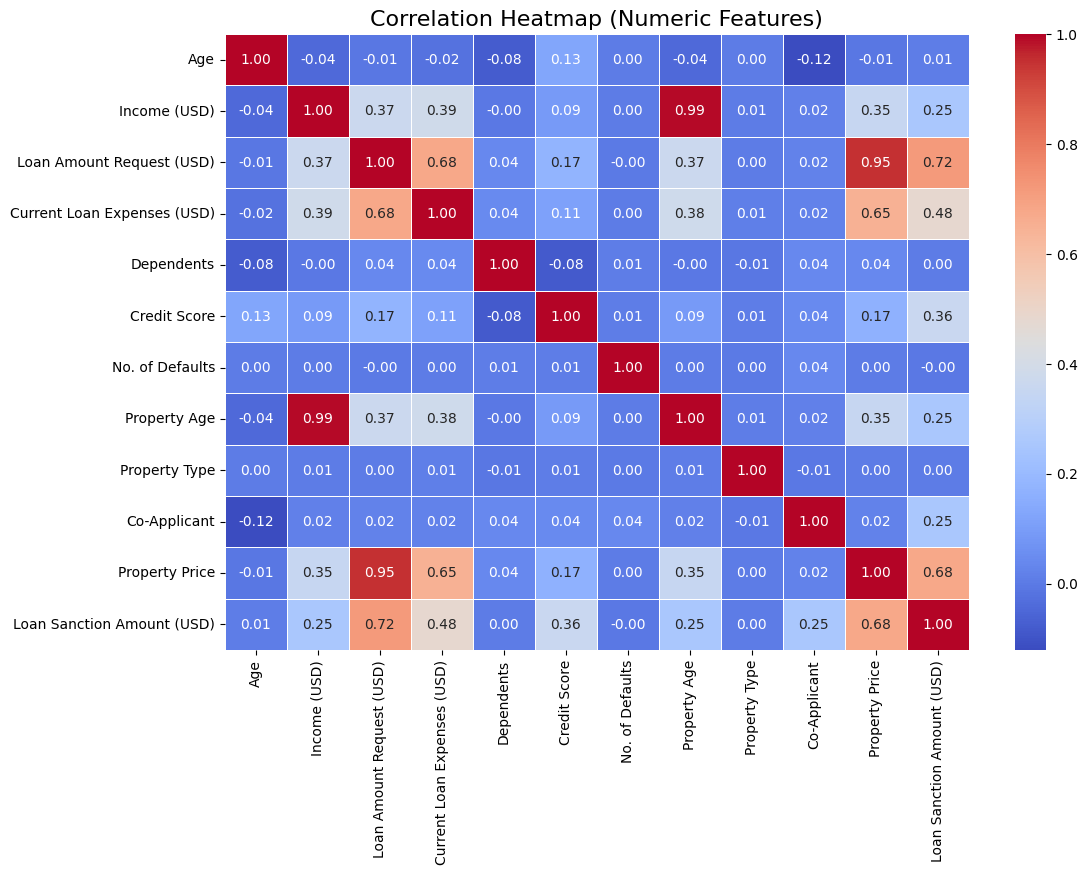


🔎 Correlation with Target Variable:
Loan Sanction Amount (USD)     1.000000
Loan Amount Request (USD)      0.718851
Property Price                 0.680155
Current Loan Expenses (USD)    0.480108
Credit Score                   0.357442
Income (USD)                   0.254782
Co-Applicant                   0.254417
Property Age                   0.251623
Age                            0.008176
Dependents                     0.004905
Property Type                  0.001960
No. of Defaults               -0.004219
Name: Loan Sanction Amount (USD), dtype: float64
Predicting on test data...

✅ Predictions are ready.
First 10 Predicted Loan Amounts:
 [ 90462.93  75370.89  85456.62  46398.6   73405.91 -30955.22  84271.93
  92421.78   1998.91  18391.65]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# --- 1. Load Data ---
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/Colab Notebooks/EX2/train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/EX2/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Loaded the datasets")
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("-" * 30)


# --- 2. Preprocessing and Outlier Treatment ---

drop_cols = ['Customer ID', 'Name', 'Property ID', 'Expense Type 1', 'Expense Type 2']
train_df.drop(columns=drop_cols, inplace=True, errors='ignore')
test_df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Replace '?' with NaN and convert datatypes
for df in [train_df, test_df]:
    df.replace('?', np.nan, inplace=True)

    # Convert to numeric where possible
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    # Fill numeric with mean, categorical with mode
    for col in df.select_dtypes(include=['float64', 'int64']):
        df[col] = df[col].fillna(df[col].median())
    for col in df.select_dtypes(include=['object']):
        df[col] = df[col].fillna(df[col].mode()[0])

# Fix Co-Applicant corrupted values
train_df['Co-Applicant'] = train_df['Co-Applicant'].replace(-999, 0)
if 'Co-Applicant' in test_df.columns:
    test_df['Co-Applicant'] = test_df['Co-Applicant'].replace(-999, 0)

# Clip outliers
outlier_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Property Price', 'Property Age']
for col in outlier_cols:
    if col in train_df.columns:
        q_low = train_df[col].quantile(0.01)
        q_hi = train_df[col].quantile(0.99)
        train_df[col] = train_df[col].clip(lower=q_low, upper=q_hi)
        if col in test_df.columns:
            test_df[col] = test_df[col].clip(lower=q_low, upper=q_hi)

print("Preprocessing complete.")
print("-" * 30)


# --- 3. Define Features and Target ---
X = train_df.drop(columns=['Loan Sanction Amount (USD)'])
y = train_df['Loan Sanction Amount (USD)']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
X_test = test_df


# --- 4. Create Pipeline using Linear Regression ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include='number').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Linear Regression pipeline ready.")
print("-" * 30)


# --- 5. K-Fold Cross-Validation ---
print("Performing 5-Fold Cross-Validation with Linear Regression...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring='r2')

print("-" * 30)
print(f"📊 Cross-Validation R² Scores: {np.round(scores, 3)}")
print(f"📉 Average R² Score: {scores.mean():.4f}")
print(f"📈 Standard Deviation of R²: {scores.std():.4f}")
print("-" * 30)


# --- 6. Train Final Model & Predict ---
print("Training final Linear Regression model...")
model_pipeline.fit(x_train, y_train)

y_pred=model_pipeline.predict(x_test)

r2=r2_score(y_test,y_pred)

print("*** R2 SCORE: ",r2)

#Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted (Validation Set)', fontsize=14)
plt.xlabel('Actual Loan Sanction Amount (USD)')
plt.ylabel('Predicted Loan Sanction Amount (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap with Target ---
plt.figure(figsize=(12, 8))
# Include only numeric columns + target
corr_matrix = train_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=16)
plt.show()

# Optional: Sort correlations with target for quick view
print("\n🔎 Correlation with Target Variable:")
print(corr_matrix['Loan Sanction Amount (USD)'].sort_values(ascending=False))


print("Predicting on test data...")
predictions = model_pipeline.predict(X_test)

print("\n✅ Predictions are ready.")
print("First 10 Predicted Loan Amounts:\n", np.round(predictions[:10], 2))

# Optional: Save predictions
# pd.DataFrame({'Predicted Loan Sanction Amount (USD)': predictions}).to_csv('linear_predictions.csv', index=False)
